In [1]:
"""
Training a denoising autoencoder.
Again on MNIST dataset.
"""

'\nTraining a denoising autoencoder.\nAgain on MNIST dataset.\n'

In [2]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.datasets import mnist 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
#loading MNIST dataset
(x_train,_),(x_test,_) = mnist.load_data()

In [5]:
#reshape to (28,28,1) and normalize input images 

image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size, image_size,1])
x_test = np.reshape(x_test,[-1,image_size, image_size,1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [6]:
#generate corrupted MNIST images by adding noise with normal dist centered at 0.5 and std = 0.5 

noise = np.random.normal(loc=0.5,scale=0.5,size=x_train.shape)
x_train_noisy = x_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

In [7]:
#adding noise may exceed normalized pixel values>1.0 or <0.0
#clip pixel values >1.0 and <0.0 to 0.0

x_train_noisy = np.clip(x_train_noisy,0.,1.)
x_test_noisy = np.clip(x_test_noisy,0.,1.)

In [8]:
#network parameters 

input_shape = (image_size, image_size,1)
batch_size = 32
kernel_size = 3
latent_dim = 16

#encoder/decoder number of CNN layers and filters per layer
layer_filters = [32,64]

In [9]:
#build the autoencoder model
#first the encoder part 

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

In [10]:
#stack of Conv2D(32)-Conv2D(64)

for filters in layer_filters:
    
    x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=2,
              activation='relu',
              padding='same')(x)

In [11]:
#shape info need to build decoder model so we do not need to do hand computation 
#the input to the decoder first Conv2DTranspose will have this shape 
#shape is (7,7,64) which can be processed by the decoder back to (28,28,1)

shape = K.int_shape(x)

In [12]:
#generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [13]:
#insantiate encoder mode
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [14]:
#build the decoder model
latent_inputs = Input(shape=(latent_dim,),name='decoder_input')

#use the shape (7,7,64) that was earlier saved
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
#from vector to suitable shape for transposed conv
x = Reshape((shape[1],shape[2],shape[3]))(x)

In [15]:
#stack of Conv2DTranspose(64)-Conv2DTranspose(32)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       activation='relu',
                       padding='same')(x)

In [16]:
#reconstruct the denoised input

outputs = Conv2DTranspose(filters=1,
                         kernel_size=kernel_size,
                         padding='same',
                         activation='sigmoid',
                         name='decoder_output')(x)

In [17]:
#insantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

In [18]:
#autoencoder = encoder + decoder
#instantiate autoencoder model 

autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Mean Square Error (MSE) loss function, Adam Optimizer

autoencoder.compile(loss='mse',optimizer='adam')

In [20]:
#train the autoencoder

autoencoder.fit(x_train_noisy,
               x_train,
               validation_data=(x_test_noisy,x_test),
               epochs=40,
               batch_size=batch_size)

Epoch 1/40
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0349 - val_loss: 0.0201
Epoch 2/40
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 3/40
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 4/40
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 5/40
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 6/40
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 7/40
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 8/40
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0156 - val_loss: 0.0159
Epoch 9/40
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 10/40
1875/1875 [==============================] - 57s 30m

In [21]:
#preduct the autoencoder output from corrupted test images 

x_decoded = autoencoder.predict(x_test_noisy)

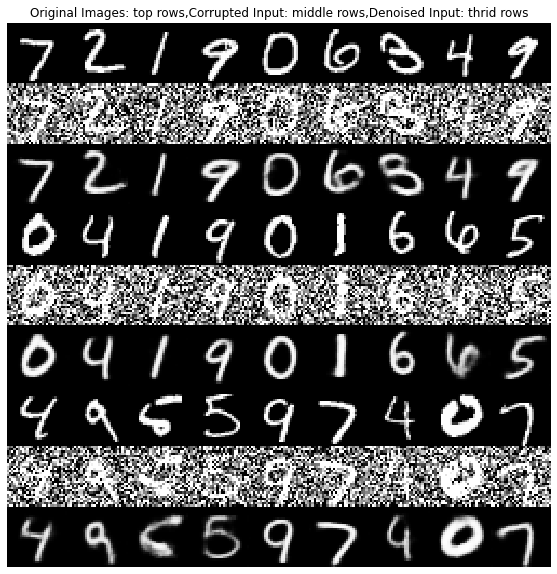

In [22]:
#3 sets of image with 9 MNIST digits
#1st rows - original image
#2nd rows images corrupted by noise
#3rd tows - denoised images

rows, cols, = 3,9
num = rows* cols

imgs = np.concatenate([x_test[:num],x_test_noisy[:num],x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3,-1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Original Images: top rows,'
         'Corrupted Input: middle rows,'
         'Denoised Input: thrid rows')
plt.imshow(imgs, interpolation='none',cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()